# Image Caption Generator 



### -Mrinalini Injeti Ramakanth
### -Omkar Reddy Gojala

## Introduction

Without the deeplearning and AI algorithms, this problem was very different to solve even for computer scientists because normal computers cannot understand the images as humans do. With the aid of Deep learning we can solve this problem easily.

Image caption generator is an interesting task where both computer vision techniques and natural language processing techniques are explored to recognize the context of an image and outline them in a natural language like English.


## Problem Description

Image Caption Generation involves predicting a sequence of words(sentence) from an input image. It is essentially an advanced image classification problem with a lot of potential applications like:

• Aiding visually impaired people who rely on sounds and texts to describe a scene


• Targeted marketing on social media applications like Facebook and Instagram


• A slightly (not-so) long term use case would be explaining what happens in a video, frame by frame



## Objective

The Objective of our project is to build a working model of image caption generator by using CNN (Conventional Neural networks) with LSTM (Long short term memory), RNN and GRU.
In simple words, Our goal is to build a model which takes an image as input and outputs its caption.

## Dataset


We are using Flickr8K dataset for image caption generation available in Kaggle[2]. 

Flickr8K.zip comprises of two folders:
    
    
• Flickr8K_Images: Contains a total of 8000 jpeg images of different shapes and sizes. We are using 6000 images for training, 1000 images for testing and 1000 images for validation
    

• Flickr8K_TextData: Contains text files describing the images in the train, validation and the test sets. Each image has a total of 5 captions i.e. a total of 40000 captions

The dataset consists of images gathered from different Flickr groups, so the Flickr8K dataset contains a variety of images depicting scenes and situations. The images are currently of different dimensions i.e. 415x502, 500x332, 333x500 etc.

#### The entire dataset is available on the following one drive link:

https://northeastern-my.sharepoint.com/:f:/g/personal/thakkar_pu_northeastern_edu/EjVjwgfSpXpNv7Vnqjp9b-ABFifM6Bvexbr2b-Icre9Glw?e=b0VBRB



### Importing all the necessary libraries and packages. 

In [1]:
import csv
import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt
from string import punctuation
import cv2
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt

from os import listdir
from pickle import dump
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

import pickle
import operator
import seaborn as sns
import keras
import glob

import nltk
from nltk.translate.bleu_score import corpus_bleu

import seaborn as sns
from keras.callbacks import ModelCheckpoint
from numpy.random import seed
from string import punctuation

from keras.layers import Input
from keras.models import Model
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer

from keras.layers import Input, Dense, Concatenate, Dropout, Embedding, add
from keras.layers.recurrent import LSTM, GRU, SimpleRNN


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Extracting the image descriptions from the tokens file

In [2]:
pd.set_option('display.max_colwidth', -1)
df = pd.read_csv('Flickr8k_text/Flickr8k.token.txt', sep="\t", names=['Image_Name','Image_Caption'],header=None)

new_df = df.copy()
new_df["Image_Name"]= new_df.iloc[:,0].str.slice(0,-2)

In [3]:
new_df

,Image_Name,Image_Caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
...,...,...
40455,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40456,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40457,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock face covered in assist handles .
40458,997722733_0cb5439472.jpg,A rock climber in a red shirt .


### Data Cleaning

Convert all words to lowercase.

Remove all punctuation.

Remove all words that are one character or less in length (e.g. ‘a’).

Remove all words with numbers in them

The data is not readily available to feed into the model and it is not necessarily clean which will have a significant mpact on the analysis. Our dataset contains noisy data like numbers, some special characters and symbols. 
  
In this step, we have deleted the numbers, punctuations, and extra white spaces also converted the words into the lower case. The method vocab used below will give us the number of unique words in our dataset which contains a total of 8763 unique words

In [4]:
imageDescription = dict()

for rows in new_df.iterrows():
    if rows[1][0] not in imageDescription.keys():
        imageDescription[rows[1][0]] = [rows[1][1]]
    else:
        imageDescription[rows[1][0]].append(rows[1][1])

table = str.maketrans('', '', punctuation)
        
new_dict = {k: [sentence.lower() for sentence in v] for k, v in imageDescription.items()}
new_dict = {k: [sentence.translate(table) for sentence in new_dict[k]] for k in new_dict}
new_dict = {k:[' '.join([word for word in sentence.split(" ") if len(word)>1 and word.isalpha()]) for sentence in new_dict[k]]for k in new_dict}

vocabulary = set()
for key in new_dict.keys():
    [vocabulary.update(d.split()) for d in new_dict[key]]
print('Total Vocabulary Size: %d' % len(vocabulary))

Total Vocabulary Size: 8763


In [5]:
captions=[]
word_count= dict()

for v in new_dict.values():
    for sentence in v:
        captions.append(sentence)

for sent in captions:
    word = sent.split(" ")
    for w in word: 
        if w in word_count:
            word_count[w] += 1
        else:
            word_count[w] = 1
            
vocab = [w for w in word_count if word_count[w] >= 10]

## Plotting the word counts

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text major ticklabel objects>)

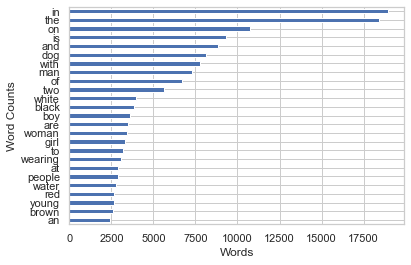

In [8]:
sorted_d = pd.DataFrame(sorted(word_count.items(), key=operator.itemgetter(1),reverse=True))
sorted_d.columns = ["Word","Word_Count"]
s = sorted_d.head(25)
s.plot(x="Word",y="Word_Count",kind='barh',legend=None).invert_yaxis()
plt.xlabel("Words")
plt.ylabel("Word Counts")
plt.yticks(rotation=0)


## Freqeuncy of Words in Captions

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text major ticklabel objects>)

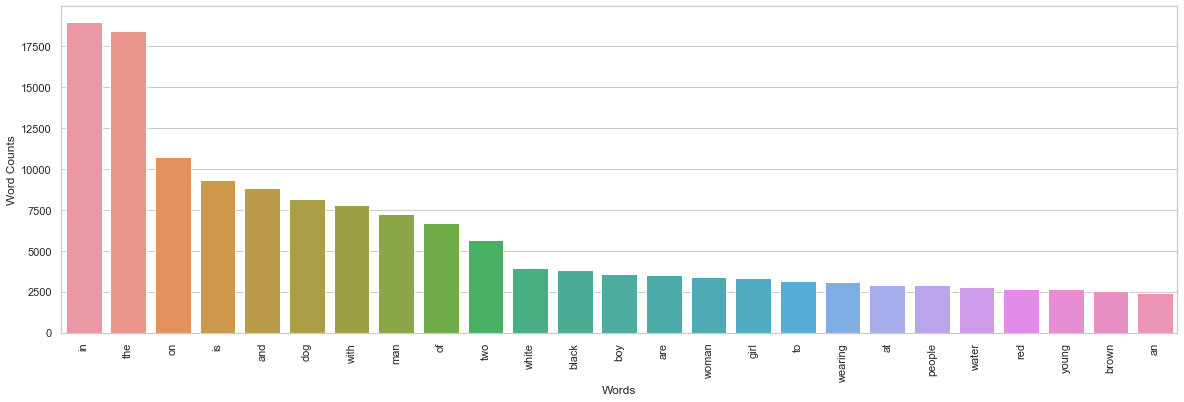

In [9]:
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(20,6))
sns.barplot(x=s["Word"],y=s["Word_Count"])
plt.xlabel("Words")
plt.ylabel("Word Counts")
plt.xticks(rotation='vertical')

### Creating train,test and dev ditconary for the images.tct files

In [10]:
pd.set_option('display.max_colwidth', -1)
train_df = pd.read_csv('Flickr8k_text/Flickr_8k.trainImages.txt', names=['Image_Name'],header=None)
test_df = pd.read_csv('Flickr8k_text/Flickr_8k.testImages.txt', names=['Image_Name'],header=None)
dev_df = pd.read_csv('Flickr8k_text/Flickr_8k.devImages.txt', names=['Image_Name'],header=None)
train_dict = dict()

for i in range(len(train_df)):
    if train_df.iloc[i][0] in new_dict.keys():
        caption_list = new_dict.get(train_df.iloc[i][0])
        for sentence in caption_list:
            s ='startseq ' + (sentence) + ' endseq'
            if train_df.iloc[i][0] not in train_dict.keys():
                train_dict[train_df.iloc[i][0]] = [s]
            else:
                train_dict[train_df.iloc[i][0]].append(s)

In [11]:
dev_dict = dict()

for i in range(len(dev_df)):
    if dev_df.iloc[i][0] in new_dict.keys():
        caption_list = new_dict.get(dev_df.iloc[i][0])
        for sentence in caption_list:
            s ='startseq ' + (sentence) + ' endseq'
            if dev_df.iloc[i][0] not in dev_dict.keys():
                dev_dict[dev_df.iloc[i][0]] = [s]
            else:
                dev_dict[dev_df.iloc[i][0]].append(s)

In [13]:
test_dict = dict()
for i in range(len(test_df)):
    if test_df.iloc[i][0] in new_dict.keys():
        caption_list = new_dict.get(test_df.iloc[i][0])
        for sentence in caption_list:
            s ='startseq ' + (sentence) + ' endseq'
            if test_df.iloc[i][0] not in test_dict.keys():
                test_dict[test_df.iloc[i][0]] = [s]
            else:
                test_dict[test_df.iloc[i][0]].append(s)

## Reading the images and resizing for CNN

In [14]:
images = []
image_names = []
image_dir = 'Flicker8k_Dataset/*.jpg'
for img in glob.glob(image_dir):
    x = img.split("/")
    name = x[1].split("\\")
    image_names.append(name[0])
    cv_img = cv2.imread(img)
    img_resize = cv2.resize(cv_img, (299,299))
    images.append(img_resize)


## Using Transfer Learning Inception-v3 pre-trained model

 We had a pre-trained model for that we have transferred the learning with our train data because without this way the model would take more time and more training.

Transfer learning is a machine learning method which utilizes a pre-trained neural network. 
The image recognition model called Inception-v3 consists of two parts:


1.Feature extraction part with a convolutional neural network.


2.Classification part with fully-connected and softmax layers.

Inception-v3 is a pre-trained convolutional neural network model that is 48 layers deep

This pre-trained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. As a result, the network has learned rich feature representations for a wide range of images. The network has an image input size of 299-by-299. 

The model extracts general features from input images in the first part and classifies them based on those features in the second part.

Inception v3 is a widely-used image recognition model that has been shown to attain greater than 78.1% accuracy on the ImageNet dataset and around 93.9% accuracy in top 5 result


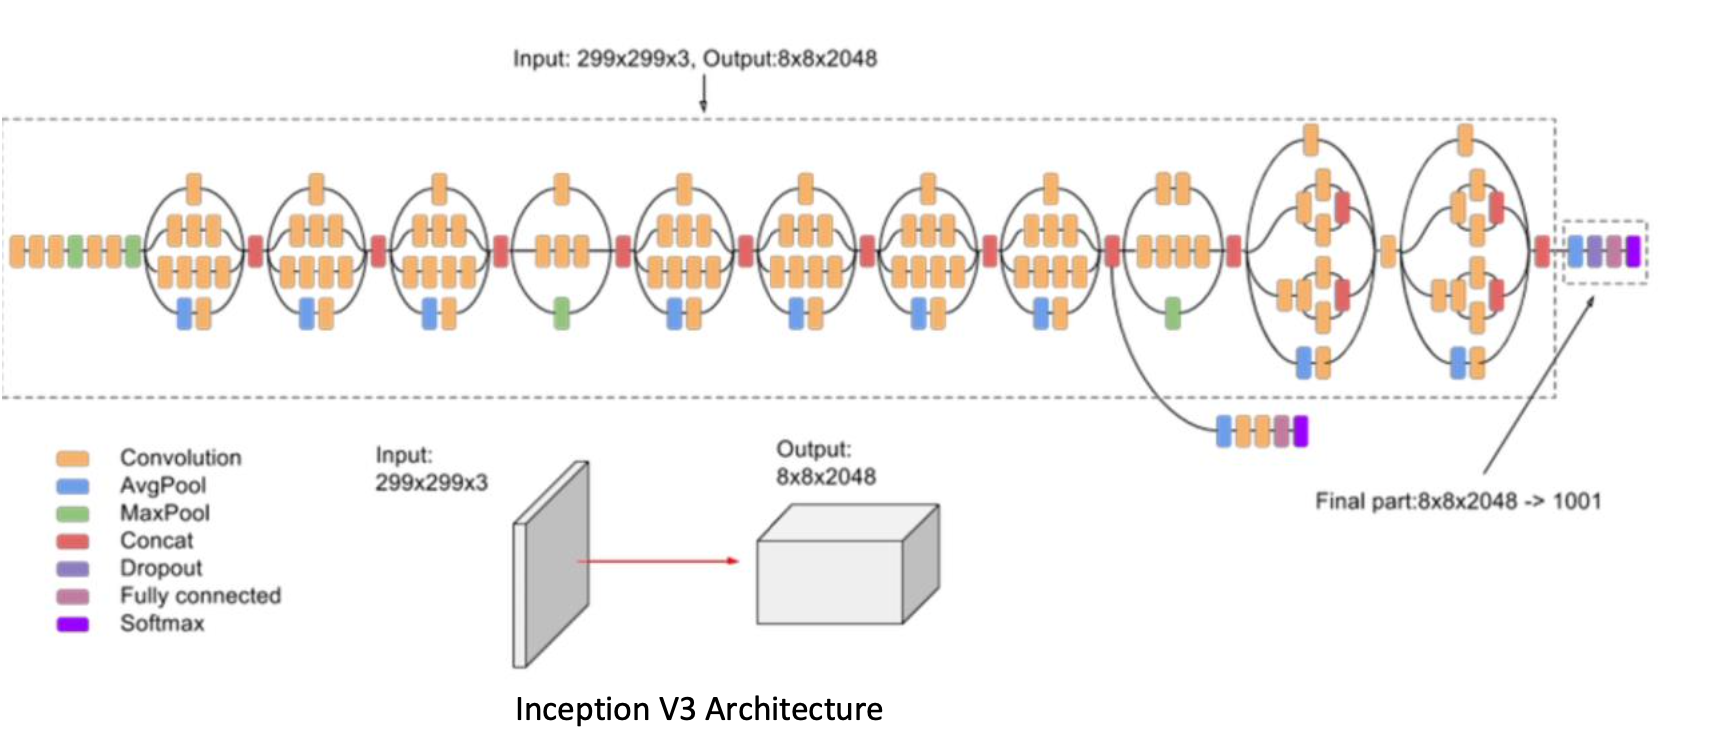

In [15]:
#Loading the Inception-v3 model

model = InceptionV3(weights='imagenet')
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [17]:
# Removing the last layer from the inception v3 for creating new model

model_new = Model(model.input, model.layers[-2].output)
model_new.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

### Creates image dictionary with name of image as key : feature vector as value (takes about an hour to load)

In [18]:
image_dict = {}
for i in range(len(images)):
    x = preprocess_input(images[i])
    x = np.resize(x,(1,299,299,3))
    preds = model_new.predict(x)
    preds = np.reshape(preds, preds.shape[1])
    image_dict[image_names[i]] = preds

### Creating seperate dataframes for train, test and validation images to create pickle files

In [19]:
train_images= {}
test_images = {}
dev_images = {}

for i in range(len(train_df)):
    if train_df.iloc[i][0] in image_dict.keys():
        train_images[train_df.iloc[i][0]] = image_dict.get(train_df.iloc[i][0])

for i in range(len(test_df)):
    if test_df.iloc[i][0] in image_dict.keys():
        test_images[test_df.iloc[i][0]] = image_dict.get(test_df.iloc[i][0])

for i in range(len(dev_df)):
    if dev_df.iloc[i][0] in image_dict.keys():
        dev_images[dev_df.iloc[i][0]] = image_dict.get(dev_df.iloc[i][0])


### Dumping the data into pickle Files

In [20]:
pickle.dump(train_images, open("encoded_train_images_v3_latest.pkl", "wb"))
pickle.dump(test_images, open("encoded_test_images_v3_latest.pkl", "wb"))
pickle.dump(dev_images, open("encoded_dev_images_v3_latest.pkl","wb"))

### Loading the data from Pickle Files

In [25]:
encoded_train_v3 = pickle.load(open("encoded_train_images_v3_latest.pkl","rb"))
encoded_test_v3 = pickle.load(open("encoded_test_images_v3_latest.pkl","rb"))
encoded_validation_v3 = pickle.load(open("encoded_dev_images_v3_latest.pkl","rb"))

### Calcuate the max length of the description so that we can use this length as reference in the caption generation.

In [26]:
captionsList =[]

for l in train_dict.values():
    for i in l:
        captionsList.append(i)

maxLendesc = max(len(c.split(" ")) for c in captionsList)
print("Max Description length : ",maxLendesc)

Max Description length :  34


## Data Preparation using Create Seqence Function

This is the main part of the image captioning. This function prepares the data which will be suitable to be given as input to the deep learning model. 
First images with 2048 feature-length vector and partial caption are given as input to the model. Starting, we provide only the image vector and the first word as input and try to predict the second word
     
   Input = Image_1 + ‘startseq’; Output = ‘the’

After that we provide image vector and the first two words as input and try to predict the third word, i.e.:
    
  Input = Image_1 + ‘startseq the’; Output = ‘dog’ And so on...
  

| Image Feature Vector | Partial Caption | Targetword |
| --- | --- | --- |
| Image_1 |startseq | black |
| Image_1 |startseq black | dog |
| Image_1 |startseq blackdog | is |
| Image_1 |startseq black dog is | running |
| Image_1 |startseq black dog is running| through |
| Image_1 |startseq black dog is running through| the |
| Image_1 |startseq black dog is running through the | grass |
| Image_1 |startseq black dog is running through the grass| endseq |

In [27]:
tokenizer = Tokenizer()
t = tokenizer.fit_on_texts(captionsList)
vocab_size = len(tokenizer.word_index)+1

def createSequence(tokenizer, maxLendesc,train_dict, images, vocab_size):
    X1, X2, y = list(), list(), list()
    for image, captions in train_dict.items():
        for line in captions:
            seq = tokenizer.texts_to_sequences([line])[0]
            for i in range(1,len(seq)):
                input_seq, output_seq = seq[:i], seq[i]
                input_seq = pad_sequences([input_seq], maxlen=maxLendesc)[0] #dtype='int32', padding='post', truncating='post', value=0.0)[0]
                output_seq = to_categorical([output_seq], num_classes=vocab_size)[0]#, dtype='int32')[0]
                X1.append(images[image])
                X2.append(input_seq)
                y.append(output_seq)
    return np.array(X1), np.array(X2), np.array(y)
    
X1_train, X2_train, y_train = createSequence(tokenizer, maxLendesc,train_dict, encoded_train_v3, vocab_size)
X1_test, X2_test, y_test = createSequence(tokenizer, maxLendesc,dev_dict, encoded_validation_v3, vocab_size)

## Building the Neural Network


## Model Architecture

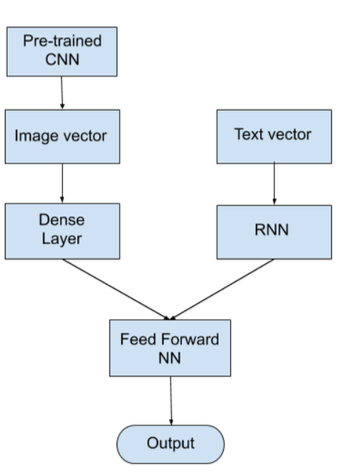

• In this model we are using an encoder-decoder architecture

• The 2048 image vector generated from the pretrained CNN model is fed into a dense layer with 256 nodes, to
obtain a fixed length image vector of 256

• The 34-length word vector is fed into an embedding LSTM/GRU/SimpleRNN layer with 256 nodes to generate
a 256 fixed length word vector

• The 256-length image and word vector are considered as the encoder outputs

• Decoder model adds both the encoder outputs and feeds it into dense 256 layer

• The output layer is a dense layer with 8763 nodes (size of the vocabulary) followed by a softmax layer, which
will output probabilities for each word in the vocabulary. The maximum probability word will be predicted as
the next word in the description

### We used three different recurrent neural networks to generate captions, namely Long Term-Short Term Memory, Simple Recurrent Neural Network and Gated Recurrent Unit. 

Long short-term memory is an artificial recurrent neural network architecture used in the field of deep learning. LSTM have feedback connections which can process entire sequences of Data. They are a type of RNN (recurrent neural network) which is well suited for sequence prediction problems. LSTM can carry relevant information throughout the processing of inputs and discards non-relevant information.

The difference between an RNN and a Feed-Forward Neural Network is that in an RNN, the nodes loop the input data, which is what allows information to be outputted. In the diagram, Xt is the initial input, while Xt is the final output. The input undergoes multiple iterations (which you can see at X0, X1, and X2) which is why it’s called recurrent. It uses the output of the first iteration for the input (which affects the output) of the second. Basically, it gives context to the data

The Gated Recurrent Unit is a new gating mechanism introduced in 2014, it is a newer generation of RNN. GRU is similar to LSTM and has shown that it performs better on smaller datasets. Unlike LSTM, GRU has only two gates, a reset gate and an update gate and they lack output gate. GRU’s got itself free of the cell state and instead uses the hidden state to transfer information.

In [47]:
def model_LSTM_FFNN(maxLendesc,vocab_size):
    # Image feature extraction
    in1 = Input(shape=(2048,))
    featureExtracted1 = Dropout(0.5)(in1)
    featureExtracted2 = Dense(256, activation='relu')(featureExtracted1)

    # Captions
    in2 = Input(shape=(maxLendesc,))
    sentenceExtraction1 = Embedding(vocab_size, 256, mask_zero=True)(in2) # input_dim = vocab_size, output_dim = 256
    sentenceExtraction2 = Dropout(0.5)(sentenceExtraction1)
    sentenceExtraction3 = LSTM(256)(sentenceExtraction2)

    # Input to the feed forward NN
    ff1 = add([featureExtracted2,sentenceExtraction3])
    ff2 = Dense(256, activation="relu")(ff1)
    ff_out = Dense(vocab_size, activation="softmax")(ff2)

    model = Model(inputs=[in1,in2], outputs=ff_out) # All the inputs required to compute the output
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy']) #Configures the model for training

    print(model.summary())
    return model

def model_RNN_FFNN(maxLendesc,vocab_size):
    # Image feature extraction
    in1 = Input(shape=(2048,))
    featureExtracted1 = Dropout(0.5)(in1)
    featureExtracted2 = Dense(256, activation='relu')(featureExtracted1)
    
    # Captions
    in2 = Input(shape=(maxLendesc,))
    sentenceExtraction1 = Embedding(vocab_size, 256, mask_zero=True)(in2) # input_dim = vocab_size, output_dim = 256
    sentenceExtraction2 = Dropout(0.5)(sentenceExtraction1)
    sentenceExtraction3 = SimpleRNN(256)(sentenceExtraction2)
    
    # Input to the feed forward NN
    ff1 = add([featureExtracted2,sentenceExtraction3])
    ff2 = Dense(256, activation="relu")(ff1)
    ff_out = Dense(vocab_size, activation="softmax")(ff2)
    
    model = Model(inputs=[in1,in2], outputs=ff_out) # All the inputs required to compute the output
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy']) #Configures the model for training
    
    print(model.summary())
    return model

def model_GRU_FFNN(maxLendesc,vocab_size):
    # Image feature extraction
    in1 = Input(shape=(2048,))
    featureExtracted1 = Dropout(0.5)(in1)
    featureExtracted2 = Dense(256, activation='relu')(featureExtracted1)
    
    # Captions
    in2 = Input(shape=(maxLendesc,))
    sentenceExtraction1 = Embedding(vocab_size, 256, mask_zero=True)(in2) # input_dim = vocab_size, output_dim = 256
    sentenceExtraction2 = Dropout(0.5)(sentenceExtraction1)
    sentenceExtraction3 = GRU(256)(sentenceExtraction2)
    
    # Input to the feed forward NN
    ff1 = add([featureExtracted2,sentenceExtraction3])
    ff2 = Dense(256, activation="relu")(ff1)
    ff_out = Dense(vocab_size, activation="softmax")(ff2)
    
    model = Model(inputs=[in1,in2], outputs=ff_out) # All the inputs required to compute the output
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy']) #Configures the model for training
    
    print(model.summary())
    return model

### Each of the models were run for 20 Epochs and it took about 5 hours to train all neural networks altogehter on a 16GB RAM 

## Training the Neural Network- LSTM

In [29]:
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
epochs=20
model = model_LSTM_FFNN(maxLendesc,vocab_size) 
for i in range(epochs):
    model.fit([X1_train, X2_train], y_train, epochs=1, verbose=2, callbacks=[checkpoint], validation_data=([X1_test, X2_test], y_test))
    model.save('modelLSTM_' + str(i) + '.h5')

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 256)      1940224     input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
_______________________________________________________________________________________

## Training the Neural Network- RNN


In [48]:
filepath = 'modelRNN-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
epochs=20
model = model_RNN_FFNN(maxLendesc,vocab_size) 
for i in range(epochs):
    model.fit([X1_train, X2_train], y_train, epochs=1, verbose=2, callbacks=[checkpoint], validation_data=([X1_test, X2_test], y_test))
    model.save('modelRNN_' + str(i) + '.h5')

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 256)      1940224     input_5[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 2048)         0           input_4[0][0]                    
_______________________________________________________________________________________

## Training the Neural Network- GRU

In [49]:
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
epochs=20
model = model_GRU_FFNN(maxLendesc,vocab_size) 
for i in range(epochs):
    model.fit([X1_train, X2_train], y_train, epochs=1, verbose=1, validation_data=([X1_test, X2_test], y_test))
    model.save('modelGRU_' + str(i) + '.h5')

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 34, 256)      1940224     input_7[0][0]                    
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 2048)         0           input_6[0][0]                    
_______________________________________________________________________________________

## Predicting the captions for each test image

In [30]:
def get_word(prediction, tokenizer):
    word = tokenizer.index_word[prediction]
    return word

def get_description(model, photo_feature, tokenizer, max_word_len):
    desc =  'startseq'
    for i in range(max_word_len):
        word_vector = tokenizer.texts_to_sequences([desc])[0]
        word_vector = pad_sequences([word_vector], maxlen=max_word_len)#, dtype='int32', padding='post', truncating='post', value=0.0)#[0]
        prediction = model.predict([photo_feature.reshape(1,2048), word_vector], verbose=0)
        prediction = np.argmax(prediction)
        word = get_word(prediction, tokenizer)
        desc += " "+str(word)
        if word == 'endseq':
            break
        i += 1
    return desc

### Test Caption Generation- LSTM

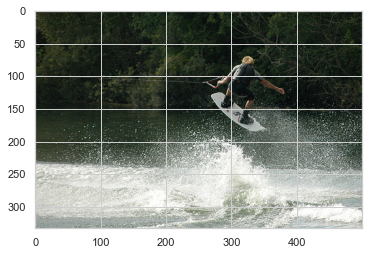

Actual Prediction:
['startseq man gets lots of air time as he wakeboards endseq', 'startseq man is waterskiing on one ski and jumping out of the water endseq', 'startseq wakeboarder leaps in the air endseq', 'startseq waterskier is jumping through the air whilst holding onto the line endseq', 'startseq the man on the board uses the wave to jump high into the air endseq']
-----------------------------------------
Our Prediction
startseq man rides the wave endseq


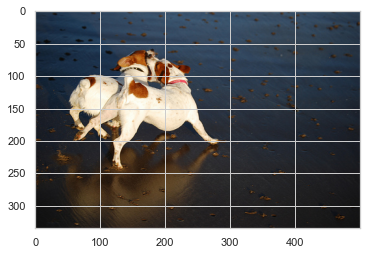

Actual Prediction:
['startseq dogs chase each other endseq', 'startseq two brown and white dogs wrestle while running across the wet sand endseq', 'startseq two dogs identical white with brown spots wrestle on jet black sand endseq', 'startseq two white and brown dogs playing on beach endseq', 'startseq two white dogs with brown markings playing endseq']
-----------------------------------------
Our Prediction
startseq white dog is running on the beach endseq


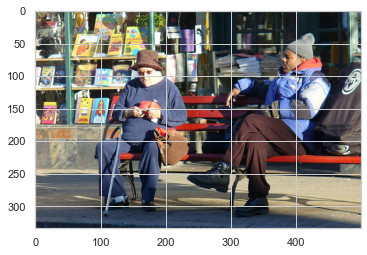

Actual Prediction:
['startseq an older man is sitting on red bench with younger man endseq', 'startseq an older person is sitting on red bench next to black man with children bookstore behind them both endseq', 'startseq person sits on red bench to eat while another watches endseq', 'startseq two men sit on bench endseq', 'startseq two people sitting on red bench in front of books endseq']
-----------------------------------------
Our Prediction
startseq man in black shirt and woman sitting on the street endseq


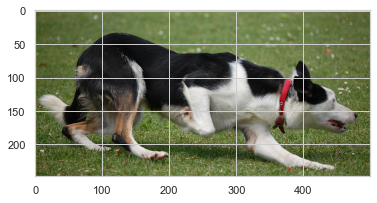

Actual Prediction:
['startseq black and white dog is wearing red collar whilst walking on the grass endseq', 'startseq dog is running awkwardly endseq', 'startseq multicolor dog in red collar crouching on the grass endseq', 'startseq black brown and white dog crouches on three legs in the grass endseq', 'startseq the dog with the red collar is white black and brown endseq']
-----------------------------------------
Our Prediction
startseq black and white dog running on the grass endseq


In [87]:
images = "Flicker8k_Dataset/"
z=0

#Loading the model previosuly run
model = keras.models.load_model('modelLSTM_19.h5')

for z in range(66,70):
    pic = list(encoded_test_v3.keys())[z]
    image = encoded_test_v3[pic].reshape((1,2048))
    x=plt.imread(images+pic)
    plt.imshow(x)
    plt.show()
    print("Actual Prediction:")
    print(test_dict[pic])
    print("-----------------------------------------")
    print("Our Prediction")
    print(get_description(model, encoded_test_v3[pic], tokenizer, maxLendesc))

### Test Caption Generation- RNN

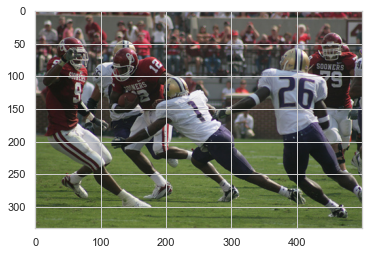

Actual Prediction:
['startseq group of football players running down the field endseq', 'startseq the crowd is watching football game endseq', 'startseq the football players in red are attempting play against those in purple white and gold endseq', 'startseq the man in red has the football and the team in white is nearby endseq', 'startseq three oklahoma sooners playing football against another team one of the sooners with the ball in their possession endseq']
-----------------------------------------
Our Prediction
startseq football player in red and white uniform in red and white jersey in the air in front of the ball in game endseq


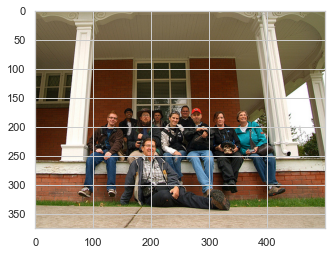

Actual Prediction:
['startseq group of people are gathered on white pillared porch for photo endseq', 'startseq group of people are sitting in front of red brick and white trim building endseq', 'startseq group of people are sitting on the porch of brick building endseq', 'startseq group of people gather in front of red house endseq', 'startseq group of ten people posing outside of classicstyle building endseq']
-----------------------------------------
Our Prediction
startseq group of people are sitting on bench in front of building endseq


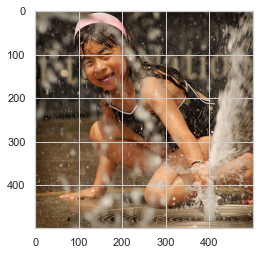

Actual Prediction:
['startseq girl with black swimsuit plays in the sprinkler endseq', 'startseq young girl is playing in fountain of water endseq', 'startseq young girl plays in fountain water endseq', 'startseq little girl crouches to splash fountain water endseq', 'startseq there is young girl in bathing suit playing with water shooting out of the ground endseq']
-----------------------------------------
Our Prediction
startseq swimmer in water and splashing in water endseq


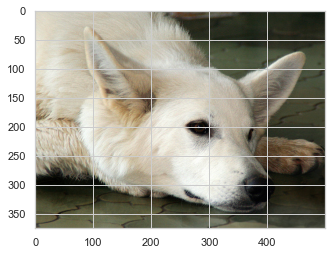

Actual Prediction:
['startseq closeup of white dog that is laying its head on its paws endseq', 'startseq large white dog lying on the floor endseq', 'startseq white dog has its head on the ground endseq', 'startseq white dog is resting its head on tiled floor with its eyes open endseq', 'startseq white dog rests its head on the patio bricks endseq']
-----------------------------------------
Our Prediction
startseq dog in the snow endseq


In [67]:
images = "Flicker8k_Dataset/"
z=0
#Loading the model previosuly run
model = keras.models.load_model('modelRNN_19.h5')

for z in range(370,374):
    pic = list(encoded_test_v3.keys())[z]
    image = encoded_test_v3[pic].reshape((1,2048))
    x=plt.imread(images+pic)
    plt.imshow(x)
    plt.show()
    print("Actual Prediction:")
    print(test_dict[pic])
    print("-----------------------------------------")
    print("Our Prediction")
    print(get_description(model, encoded_test_v3[pic], tokenizer, maxLendesc))

### Test Caption Generation- GRU

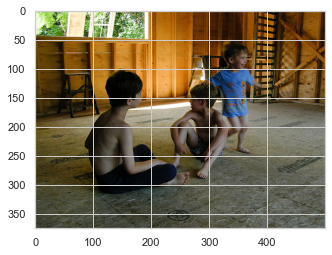

Actual Prediction:
['startseq three boys in building under construction endseq', 'startseq three boys play in an unfinished building endseq', 'startseq three boys playing in an unfinished space endseq', 'startseq three little boys are playing on the floor of an unfinished house endseq', 'startseq two young boys sit and one young boy stands on an unfinished wooden floor endseq']
-----------------------------------------
Our Prediction
startseq group of children in the water endseq


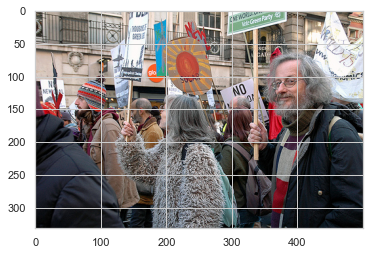

Actual Prediction:
['startseq crowd of people wearing jackets and holding signs endseq', 'startseq group of protesters picket in the road endseq', 'startseq large green peaceful protest is taken to the streets endseq', 'startseq protest march is passing by white stone building endseq', 'startseq group of people walking with posters endseq']
-----------------------------------------
Our Prediction
startseq crowd of people are gathered down street endseq


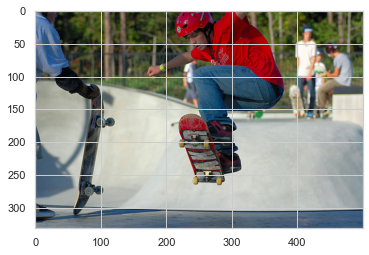

Actual Prediction:
['startseq man wearing red helmet jumps up while riding skateboard endseq', 'startseq young man wearing red jacket performs jump on red skateboard endseq', 'startseq the helmeted boy is doing stunt on skateboard endseq', 'startseq the young man is skateboarding at skate park endseq', 'startseq young man is performing trick on skateboard in park endseq']
-----------------------------------------
Our Prediction
startseq child wearing blue shirt and black pants is climbing endseq


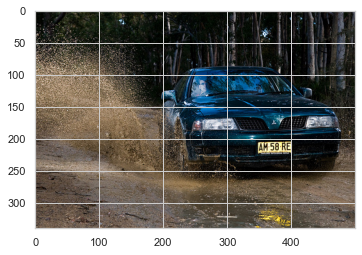

Actual Prediction:
['startseq black mitsubishi is driving through muddy puddle and spraying water endseq', 'startseq blue car splashes mud on dirt road while driving through puddle endseq', 'startseq blueish green car on dirt road splashing water on the left endseq', 'startseq dark blue car going through muddy road and sprinkling some to the side endseq', 'startseq there is blue car on road in the roads splashing through puddle endseq']
-----------------------------------------
Our Prediction
startseq man is driving through puddle endseq


In [88]:
images = "Flicker8k_Dataset/"
z=0
#Loading the model previosuly run
model = keras.models.load_model('modelGRU_19.h5')

for z in range(21,25):
    pic = list(encoded_test_v3.keys())[z]
    image = encoded_test_v3[pic].reshape((1,2048))
    x=plt.imread(images+pic)
    plt.imshow(x)
    plt.show()
    print("Actual Prediction:")
    print(test_dict[pic])
    print("-----------------------------------------")
    print("Our Prediction")
    print(get_description(model, encoded_test_v3[pic], tokenizer, maxLendesc))

## Evaluating the Performance using Bilingual Evaluation Understudy Score (BLEU) metric for each model

• BLEU is a metric for evaluating a generated sentence to a reference sentence

• BLEU score lies between 0 and 1, where a perfect match results in a score of 1 and a perfect mismatch results
in a score of 0

• It counts the matching n-grams in the generated and the reference description, where 1-gram or unigram
would be each token and a bigram comparison would be each word pair

• The n-gram comparison is made regardless of word order

• BLEU ensures that the all the occurrences in the reference text is considered


In [33]:
def evaluate_model(model, descriptions, photos, tokenizer, max_len):
    actual, predicted = list(), list()
    for key, desc_list in descriptions.items():
        predict = get_description(model, photos[key], tokenizer, max_len)
        refs = [d.split() for d in desc_list]
        actual.append(refs)
        predicted.append(predict.split())
        
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

### BLEU Score for LSTM model:


In [34]:
model = keras.models.load_model('modelLSTM_19.h5')

evaluate_model(model, test_dict, encoded_test_v3, tokenizer, maxLendesc)

BLEU-1: 0.624825
BLEU-2: 0.396498
BLEU-3: 0.290238
BLEU-4: 0.149033


### BLEU Score for RNN model:

In [56]:
model = keras.models.load_model('modelRNN_19.h5')

evaluate_model(model, test_dict, encoded_test_v3, tokenizer, maxLendesc)

BLEU-1: 0.496459
BLEU-2: 0.293420
BLEU-3: 0.211384
BLEU-4: 0.103328


### BLEU Score for GRU model:

In [57]:
model = keras.models.load_model('modelGRU_19.h5')

evaluate_model(model, test_dict, encoded_test_v3, tokenizer, maxLendesc)

BLEU-1: 0.611734
BLEU-2: 0.385810
BLEU-3: 0.285952
BLEU-4: 0.156869


## Conclusions 

#### We observed that LSTM was performing the best out of all the networks. 

The idea of a neural network generating a sentence with proper grammar by looking at an image is utterly fascinating. We were successfully able to generate some good captions, some funny captions and some not so good captions as seen from the results. 

The main reason behind the funny captions was due to the model being confused by a predominant presence of a color or object in the image that sidelines the main subject and actions in the image. 

This can be fixed using visual attention techniques like soft visual attention or gaussian visual attention that help elevate the importance of the subject and actions in the image. 

The descriptions that we generated were very small in terms of length and we attribute this to the limited amount of data that we had for training. 

Generally generative models require huge amounts of data during training to be more efficient just like any other neural network.

## Future Work

One of the future works that we are interested to pursue is training the model with Flickr32k dataset consisting of 32k images and also creating an image to speech application where the user can take a snapshot of the surroundings and get a voice feedback of what is going on in that snapshot

## References

1) https://cs.stanford.edu/people/karpathy/cvpr2015.pdf <br>
2) https://arxiv.org/abs/1411.4555 <br>
3) https://arxiv.org/abs/1703.09137 <br>
4) https://arxiv.org/abs/1708.02043 <br>
5) https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/ <br>
6) https://thinkautonomous.medium.com/rnns-in-computer-vision-image-captioning-597d5e1321d1 <br>
7) https://machinelearningmastery.com/calculate-bleu-score-for-text-python/ <br>